In [1]:
# Load standard modules
import numpy as np
import matplotlib.pyplot as plt
# Load local modules
import CommonModules.BiSplineDer as bispl
from scipy.interpolate import interp1d
from scipy.optimize import minimize, root_scalar, fsolve

from scipy.io import loadmat

In [2]:


# Load the input data

filename = '/home/devlamin/Documents/WKBeam_related/WKBacca_dev_v1/TCV_preprocess/EQUIL_TCV_72644_1.05s.mat'

data = loadmat(filename)['equil'][0, 0] 
data.dtype.names

('psi_apRp',
 'theta',
 'ptx',
 'pty',
 'ptBx',
 'ptBy',
 'ptBP',
 'ptBPHI',
 'Rp',
 'Zp',
 'ptalpha',
 'ptgpsi',
 'x',
 'y',
 'xypsin',
 'psia',
 'Bx',
 'By',
 'BPHI',
 'rho_scr',
 'ne_scr',
 'Te_scr',
 'ne_err_scr',
 'Te_err_scr',
 'rho_eq',
 'pTe',
 'pne',
 'ne_avg',
 'rho_full',
 'ne_full',
 'Te_full',
 'ne_err_full',
 'Te_err_full',
 'zZi',
 'zmi',
 'fi',
 'pzTi',
 'pzni',
 'id')

In [3]:
psi = np.array(data['psi_apRp'][0])
psi_norm = psi/np.max(psi)
theta = np.array(data['theta'][0])

Rp = np.array(data['Rp'][0][0])
Zp = np.array(data['Zp'][0][0])

pt_R = np.array(data['ptx'] + Rp)
pt_Z = np.array(data['pty'] + Zp)

ptBP = np.array(data['ptBP'])
ptBPHI = np.array(data['ptBPHI'])

ptB = np.sqrt(ptBP**2 + ptBPHI**2)

Bmax = np.max(ptB, axis=1)

In [4]:
# Change the shape of the theta arrays and pt_B, to get minima well resolved
npt_theta = len(theta)
theta_shift = np.concatenate((theta[npt_theta//2:-1]-2*np.pi, theta[:npt_theta//2]))
ptB_shift = np.concatenate((ptB[:, npt_theta//2:-1], ptB[:, :npt_theta//2]), axis=1)

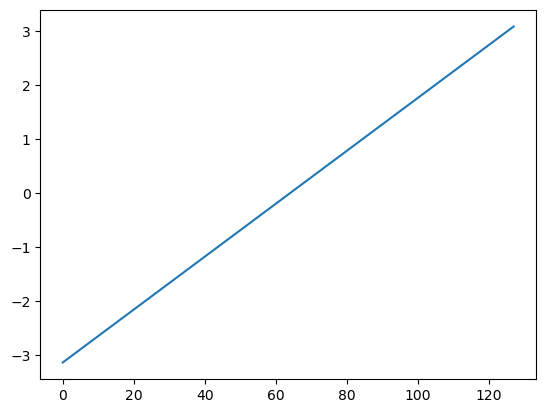

In [5]:
plt.plot(theta_shift)

In [6]:
ptB_shiftInt = bispl.BiSpline(psi_norm, theta_shift, ptB_shift)

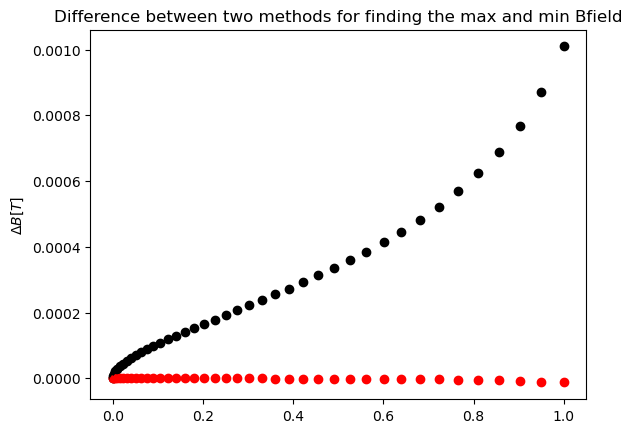

In [7]:
def minmaxB(psi_val, BInt, theta_grid):

    # Find B(theta) at the requested psi
    B_at_psi = np.array([BInt.eval(psi_val, theta) for theta in theta_grid])
    B_at_psiInt = interp1d(theta_grid, B_at_psi, kind='cubic')

    minusB_at_psi = np.array([-BInt.eval(psi_val, theta) for theta in theta_grid])
    minusB_at_psiInt = interp1d(theta_grid, minusB_at_psi, kind='cubic')

    minimum = minimize(B_at_psiInt, 0.)
    maximum = minimize(minusB_at_psiInt, -np.pi)

    return B_at_psiInt, B_at_psiInt(minimum.x), B_at_psiInt(maximum.x)

def minmaxBalt(psi_val, BInt):
    # Just return the value at theta=0 and pi
    return BInt.eval(psi_val, 0.), BInt.eval(psi_val, np.pi)


def Trapping_boundary(psi, ksi, BInt, theta_grid=[]):
    TrapB = np.zeros((len(psi), len(ksi)))
    Trapksi = np.zeros_like(psi)
    theta_roots = np.zeros((len(psi), len(ksi), 2))


    for i, psi_val in enumerate(psi):
        B_at_psiInt, B0, Bmax = minmaxB(psi_val, BInt, theta_grid)
        TrapB[i] = B0/(1-ksi**2)
        Trapksi[i] = np.sqrt(1-B0/Bmax)

        for j, ksi_val in enumerate(ksi):
            if abs(ksi_val) <= Trapksi[i]:
                def deltaB(x):
                    return B_at_psiInt(x) - TrapB[i, j]


                """
                try:
                    theta_roots[i, j, 0] = root_scalar(deltaB, bracket=[-np.pi, -1.5], method='brentq').root
                except:
                    theta_roots[i, j, 0] = np.nan
                try:
                    theta_roots[i, j, 1] = root_scalar(deltaB, bracket=[-0.15, np.pi], method='brentq').root
                except:
                    theta_roots[i, j, 1] = 0
                    """
                theta_roots[i, j] = fsolve(deltaB, [-np.pi/2, np.pi/2])
            else:
                theta_roots[i, j, 0] = np.nan
                theta_roots[i, j, 1] = np.nan

        # Now that we have the trapping boundaries, we can look for the minimal and maximal angles accesible


    
    return TrapB, Trapksi, theta_roots

for i in psi_norm:
    _, m, M = minmaxB(i, ptB_shiftInt, theta_shift)
    m2, M2 = minmaxBalt(i, ptB_shiftInt)
    plt.scatter(i, m-m2, c='r')
    plt.scatter(i, M-M2, c='k')
    plt.title('Difference between two methods for finding the max and min Bfield')
    plt.ylabel(r'$\Delta B [T]$')
    

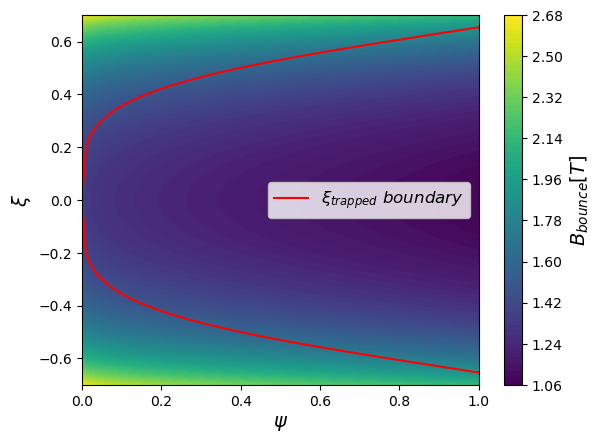

In [8]:
ksi = np.linspace(-0.7, 0.7, 150)
psi_dense = np.linspace(0, 1, 100)


Bbound, ksibound, thetasbound = Trapping_boundary(psi_dense, ksi, ptB_shiftInt, theta_shift)

a = plt.contourf(psi_dense, ksi, Bbound.T, levels=100)
plt.plot(psi_dense, ksibound, c='r', label=r'$\xi_{trapped}\ boundary$')
plt.plot(psi_dense, -ksibound, c='r')


cb = plt.colorbar(a)
cb.set_label(label=r'$B_{bounce}[T]$', size=14)
plt.xlabel(r'$\psi$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.legend(fontsize=12)


In [12]:
thetasbound.shape

(100, 150, 2)

-3.0813283786650274 nan
3.0912019214007262 nan


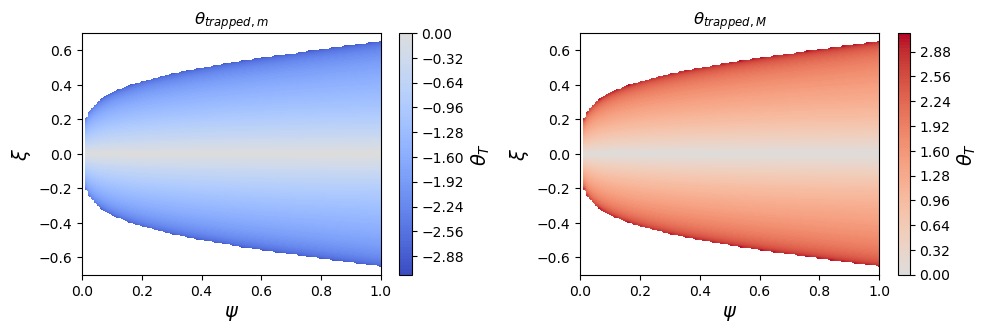

In [9]:
#create two halfs of the coolwarm colormap
from matplotlib.colors import LinearSegmentedColormap
coolwarm = plt.cm.get_cmap('coolwarm', 256)

coolmap = coolwarm(np.linspace(0, 0.5, 128))
warmmap = coolwarm(np.linspace(0.5, 1, 128))


fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

figone = ax1.contourf(psi_dense, ksi, thetasbound[:,:,0].T, levels=100, cmap=LinearSegmentedColormap.from_list('coolwarm', coolmap))
ax1.set_xlabel(r'$\psi$', fontsize=14)
ax1.set_ylabel(r'$\xi$', fontsize=14)
ax1.set_title(r'$\theta_{trapped, m}$')

figtwo = ax2.contourf(psi_dense, ksi, thetasbound[:,:,1].T, levels=100, cmap=LinearSegmentedColormap.from_list('coolwarm', warmmap))
ax2.set_xlabel(r'$\psi$', fontsize=14)
ax2.set_ylabel(r'$\xi$', fontsize=14)
ax2.set_title(r'$\theta_{trapped, M}$')


cb1 = plt.colorbar(figone, ax=ax1)
cb1.set_label(label=r'$\theta_T$', size=14)

cb2 = plt.colorbar(figtwo, ax=ax2)
cb2.set_label(label=r'$\theta_T$', size=14)

plt.tight_layout()


print(np.nanmin(thetasbound[:,:,0].flatten()), max(thetasbound[:,:,0].flatten()))
print(np.nanmax(thetasbound[:,:,1].flatten()), max(thetasbound[:,:,1].flatten()))

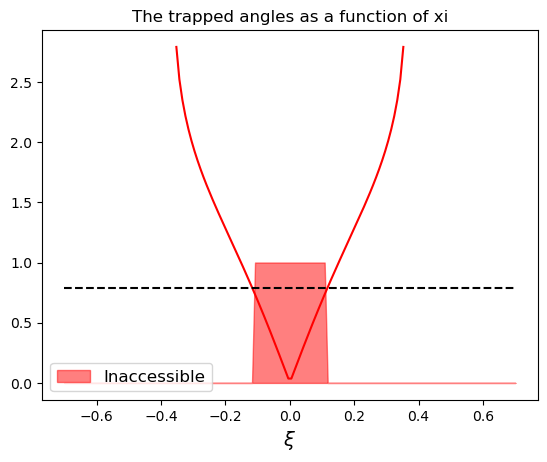

In [10]:
plt.plot(ksi, thetasbound[10,:,1], c='r')
#plt.plot(ksi, thetasbound[10,:,0], c='b')
plt.title('The trapped angles as a function of xi')
plt.xlabel(r'$\xi$', fontsize=14)
plt.hlines(np.pi/4, -0.7, 0.7, linestyle='--', color='k')
inaccessible = thetasbound[10,:,1] < np.pi/4
plt.fill_between(ksi, inaccessible, color='r', alpha=0.5, label='Inaccessible')
plt.legend(fontsize=12)

# For a given position in the plasma (theta, horizontal line)
# Only the particles that have their trapped boundary higher than the horizontal line can reach this position